In [3]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
import python_utils
from tqdm import tqdm
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')
from itertools import product
from multiprocessing import Pool


In [4]:
df = pd.read_csv('audio_features.csv')

In [5]:
from sklearn.model_selection import KFold

# Initialize KFold with the number of splits (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the 'fold' column in the DataFrame by assigning the fold number to each row
df['fold'] = -1  # Initialize the column with -1 (optional)

# Assign fold numbers
for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df.loc[val_index, 'fold'] = fold
df.head()

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,Label,fold
0,0.102608,0.660856,0.700181,0.688274,0.678534,0.651010,0.574771,0.581165,0.638042,0.667965,...,16.280880,12.099817,0.009888,0.013155,-0.037082,-0.056401,0.009007,0.007479,anger,0
1,0.093071,0.717658,0.739135,0.660817,0.664633,0.689950,0.616818,0.588072,0.604847,0.669522,...,15.335353,12.609198,-0.014074,-0.022346,-0.032157,-0.042390,0.014490,0.000316,disgust,4
2,0.084297,0.625620,0.672506,0.653072,0.656414,0.611838,0.594334,0.605105,0.674202,0.693068,...,15.585217,12.747077,-0.008795,0.036375,-0.027769,-0.036930,0.018857,0.005799,fear,2
3,0.085376,0.638848,0.668916,0.672979,0.680713,0.661755,0.661063,0.583094,0.595509,0.643509,...,16.117143,12.599001,-0.003487,0.025272,-0.045196,-0.033369,-0.004738,0.002794,happiness,0
4,0.082330,0.706375,0.680556,0.669297,0.673478,0.641603,0.580808,0.595623,0.640730,0.674372,...,16.455392,12.515949,0.018561,0.005002,-0.025166,-0.036769,0.010821,0.006420,neutral,4


In [10]:
fold_0_train = df.loc[df['fold'] != 0, df.columns[:-1]]
fold_0_test = df.loc[df['fold'] == 0, df.columns[:-1]]

fold_1_train = df.loc[df['fold'] != 1, df.columns[:-1]]
fold_1_test = df.loc[df['fold'] == 1, df.columns[:-1]]

fold_2_train = df.loc[df['fold'] != 2, df.columns[:-1]]
fold_2_test = df.loc[df['fold'] == 2, df.columns[:-1]]

fold_3_train = df.loc[df['fold'] != 3, df.columns[:-1]]
fold_3_test = df.loc[df['fold'] == 3, df.columns[:-1]]

fold_4_train = df.loc[df['fold'] != 4, df.columns[:-1]]
fold_4_test = df.loc[df['fold'] == 4, df.columns[:-1]]

fold_dfs = {0: [fold_0_train, fold_0_test],
            1: [fold_1_train, fold_1_test],
            2: [fold_2_train, fold_2_test],
            3: [fold_3_train, fold_3_test],
            4: [fold_4_train, fold_4_test]}

In [11]:
for fold in fold_dfs.keys():
  train, test = fold_dfs[fold][0], fold_dfs[fold][1]
  print('Fold {}: Train shape = {}, Test shape = {}'.format(fold, train.shape, test.shape))


Fold 0: Train shape = (8481, 176), Test shape = (2121, 176)
Fold 1: Train shape = (8481, 176), Test shape = (2121, 176)
Fold 2: Train shape = (8482, 176), Test shape = (2120, 176)
Fold 3: Train shape = (8482, 176), Test shape = (2120, 176)
Fold 4: Train shape = (8482, 176), Test shape = (2120, 176)


In [12]:
from sklearn.impute import SimpleImputer
def data_conversion(data):
    train = data[0]
    test = data[1]

    X_train = train.drop('Label', axis=1)
    y_train = train['Label']

    X_test = test.drop('Label', axis=1)
    y_test = test['Label']

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train.values)
    y_test = label_encoder.transform(y_test.values)

    label_mapping = \
    {label: encoding for label, encoding in zip(label_encoder.inverse_transform(np.unique(y_train)), np.unique(y_train))}

    # Handle missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(n_components=0.99)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return (X_train, X_test, y_train, y_test, label_mapping)

In [13]:
#performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Hyperparameters','Train AUC ROC', 'Test AUC ROC'])
#model = LogisticRegression(max_iter = 2000)
def build_and_evaluate_model(model, X_train, X_test, y_train, y_test, hyperparameters, fold, model_name):

    try:
        model = model.set_params(**hyperparameters)
        model.fit(X_train, y_train)
        y_train_pred = model.predict_proba(X_train)
        y_test_pred = model.predict_proba(X_test)

        train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
        print(f"Overall Train Data ROC-AUC: {train_auc:.2f}")
        test_auc = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')
        print(f"Overall Test Data ROC-AUC: {test_auc:.2f}")

        return model_name, fold, hyperparameters, train_auc, test_auc
    except ValueError as e:
        return model_name, fold, hyperparameters, None, None

In [14]:
import os
model = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'fit_intercept': [True, False],  # Whether to include the intercept (bias term)
    'solver': ['lbfgs', 'newton-cg', 'saga'],  # Optimization algorithm
    'l1_ratio': [0, 0.5, 1]
}

param_combinations = [dict(zip(param_grid.keys(), combo)) for combo in product(*param_grid.values())]
print(len(param_combinations))
num_processes = os.cpu_count()
print(num_processes)

144
4


In [ ]:
import time

start_time = time.time()
results = {}
for fold_ in fold_dfs.keys():
    print(fold_)
    X_train, X_test, y_train, y_test, label_mapping = data_conversion(fold_dfs[fold_])
    result = Parallel(n_jobs=num_processes)(delayed(build_and_evaluate_model)(
        model, X_train, X_test, y_train, y_test, params, fold_, 'Logistic Regression') for params in param_combinations)
    results[f'f{fold_}_result'] = result


end_time = time.time()
print(f"{(end_time - start_time)/60} minutes")

0
1


In [61]:
print(f"{(end_time - start_time)/3600} hours")

4.554231847392188 hours


In [47]:
import json
# Save dictionary to JSON file
with open('results.json', 'w') as json_file:
    json.dump(results, json_file)

In [69]:
print(results)

{'f0_result': [('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'lbfgs', 'l1_ratio': 0}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'lbfgs', 'l1_ratio': 0.5}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'lbfgs', 'l1_ratio': 1}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'newton-cg', 'l1_ratio': 0}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'newton-cg', 'l1_ratio': 0.5}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'newton-cg', 'l1_ratio': 1}, None, None), ('Logistic Regression', 0, {'penalty': 'l1', 'C': 0.1, 'fit_intercept': True, 'solver': 'saga', 'l1_ratio': 0}, np.float64(0.8727384631778566), np.float64(0.876523201322203)), ('Logistic Regression', 0, {'penalty'

In [50]:
f0 = pd.DataFrame(results['f0_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f0['diff'] = f0['Train ROC-AUC'] - f0['Test ROC-AUC']
f0.sort_values(by = 'diff', ascending=True, inplace=True)
f0 = f0[f0['Test ROC-AUC'] > 0.8]
f0.reset_index(inplace=True, drop=True)
f0.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868985,0.872843,-0.003858
1,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868986,0.872842,-0.003856
2,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868986,0.872842,-0.003855
3,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.872738,0.876527,-0.003789
4,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.872738,0.876525,-0.003787


In [51]:
f1 = pd.DataFrame(results['f1_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f1['diff'] = f1['Train ROC-AUC'] - f1['Test ROC-AUC']
f1.sort_values(by = 'diff', ascending=True, inplace=True)
f1 = f1[f1['Test ROC-AUC'] > 0.8]
f1.reset_index(inplace=True, drop=True)
f1.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,1,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.877480,0.856026,0.021453
1,Logistic Regression,1,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.877480,0.856026,0.021454
2,Logistic Regression,1,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.877480,0.856025,0.021454
3,Logistic Regression,1,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.873563,0.850396,0.023167
4,Logistic Regression,1,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.873563,0.850395,0.023168


In [52]:
f2 = pd.DataFrame(results['f2_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f2['diff'] = f2['Train ROC-AUC'] - f2['Test ROC-AUC']
f2.sort_values(by = 'diff', ascending=True, inplace=True)
f2 = f2[f2['Test ROC-AUC'] > 0.8]
f2.reset_index(inplace=True, drop=True)
f2.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,2,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.871727,0.858946,0.012781
1,Logistic Regression,2,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.871727,0.858943,0.012784
2,Logistic Regression,2,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.871727,0.858942,0.012785
3,Logistic Regression,2,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.875465,0.862368,0.013097
4,Logistic Regression,2,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.875465,0.862365,0.013100


In [53]:
f3 = pd.DataFrame(results['f3_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f3['diff'] = f3['Train ROC-AUC'] - f3['Test ROC-AUC']
f3.sort_values(by = 'diff', ascending=True, inplace=True)
f3 = f3[f3['Test ROC-AUC'] > 0.8]
f3.reset_index(inplace=True, drop=True)
f3.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,3,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.874043,0.874105,-0.000062
1,Logistic Regression,3,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.874043,0.874105,-0.000062
2,Logistic Regression,3,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.874043,0.874105,-0.000062
3,Logistic Regression,3,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.870141,0.869188,0.000953
4,Logistic Regression,3,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.870141,0.869187,0.000954


In [54]:
f4 = pd.DataFrame(results['f4_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f4['diff'] = f4['Train ROC-AUC'] - f4['Test ROC-AUC']
f4.sort_values(by = 'diff', ascending=True, inplace=True)
f4 = f4[f4['Test ROC-AUC'] > 0.8]
f4.reset_index(inplace=True, drop=True)
f4.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,4,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.878049,0.857961,0.020088
1,Logistic Regression,4,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.878049,0.857959,0.020090
2,Logistic Regression,4,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.878050,0.857958,0.020092
3,Logistic Regression,4,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.874747,0.853017,0.021729
4,Logistic Regression,4,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.874746,0.853017,0.021729


In [55]:
final_error_df = pd.concat((f0, f1, f2, f3, f4))
final_error_df.sort_values(by = 'diff', inplace=True, ascending=True)
final_error_df.reset_index(inplace=True, drop=True)
final_error_df.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868985,0.872843,-0.003858
1,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868986,0.872842,-0.003856
2,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': F...",0.868986,0.872842,-0.003855
3,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.872738,0.876527,-0.003789
4,Logistic Regression,0,"{'penalty': 'l1', 'C': 0.1, 'fit_intercept': T...",0.872738,0.876525,-0.003787


In [57]:
final_error_df.to_csv('Logistic_Regression_all_folds_errors.csv', index=False, header=True)

In [20]:
final_error_df=pd.read_csv('Logistic_Regression_all_folds_errors.csv')

In [18]:
hyperparameters = final_error_df.loc[0, 'Hyperparameters']
print(hyperparameters)

{'penalty': 'l1', 'C': 0.1, 'fit_intercept': False, 'solver': 'saga', 'l1_ratio': 0.5}


In [22]:
#performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Train AUC ROC', 'Test AUC ROC'])
#hyperparameters = final_error_df.loc[0, 'Hyperparameters']
hyperparameters = {'penalty': 'l1', 'C': 0.1, 'fit_intercept': False, 'solver': 'saga', 'l1_ratio': 0.5}
print(hyperparameters)
X_train, X_test, y_train, y_test, label_mapping = data_conversion(fold_dfs[0])
model = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')
model = model.set_params(**hyperparameters)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)
y_test_pred = model.predict_proba(X_test)

{'penalty': 'l1', 'C': 0.1, 'fit_intercept': False, 'solver': 'saga', 'l1_ratio': 0.5}


In [23]:
def generate_performance_values_plots(train_vals, test_vals, label_mapping, performance_metric_values, model_name, fold):
    f0_train_auc = roc_auc_score(train_vals[0], train_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Train Data ROC-AUC: {f0_train_auc:.2f}")
    f0_test_auc = roc_auc_score(test_vals[0], test_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Test Data ROC-AUC: {f0_test_auc:.2f}")

    error_series = pd.Series([model_name, fold, f0_train_auc, f0_test_auc], index= performance_metric_values.columns)
    #performance_metric_values = pd.concat((performance_metric_values, pd.DataFrame(error_series)))
    performance_metric_values.loc[len(df)] = error_series
    performance_metric_values.reset_index(inplace=True, drop=True)

    generate_plot(train_vals[0], train_vals[1], label_mapping, model_name, 'Train Data')
    generate_plot(test_vals[0], test_vals[1], label_mapping, model_name, 'Test Data')
    return performance_metric_values

def generate_plot(actual_classes, pred_classes, label_mapping, model_name, d_type):
    pred_classes = np.argmax(pred_classes, axis = 1)

    classes_ = list(label_mapping.values())
    # Binarize the predicted and true labels
    y_pred = label_binarize(pred_classes, classes= classes_)
    y_test = label_binarize(actual_classes, classes=classes_)

    n_classes = len(classes_)

    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize = (12, 6))
    lw = 2
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'Class {classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # Compute micro-average ROC curve and ROC-AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calculate weighted ROC-AUC
    weights = [roc_auc[i] * np.sum(y_test[:, i]) / np.sum(y_test) for i in range(n_classes)]
    roc_auc["weighted"] = sum(weights)


    # Plot the micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':')

    # Plot the weighted ROC-AUC
    plt.plot([0], [0], 'w', label='Weighted (AUC = {:.2f})'.format(roc_auc["weighted"]))

    # Add a diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC Curve for {model_name} on {d_type}')
    plt.legend(loc="lower right")
    plt.savefig(f'Multi-Class ROC Curve for {model_name} on {d_type}', dpi=300)
    plt.show()

Overall Train Data ROC-AUC: 0.87
Overall Test Data ROC-AUC: 0.87


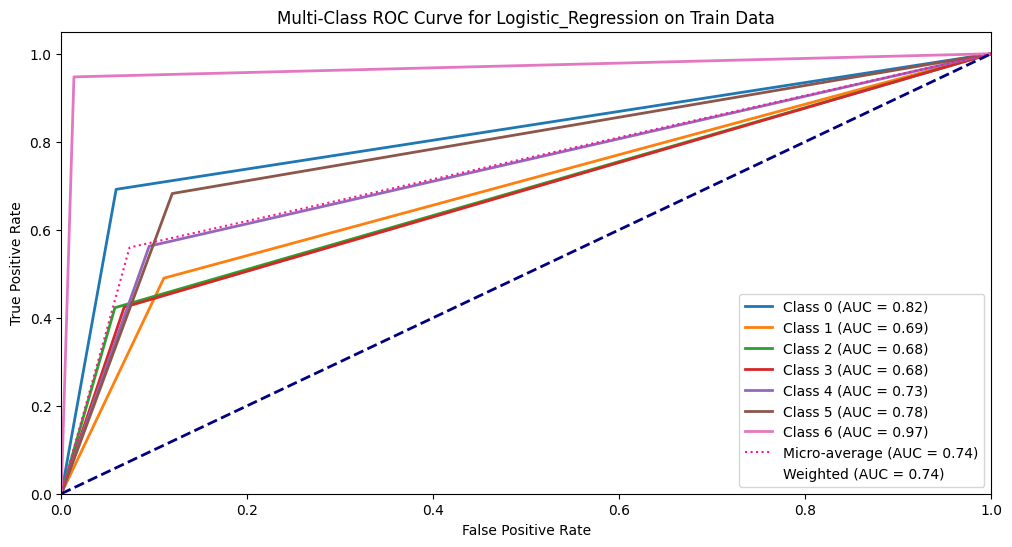

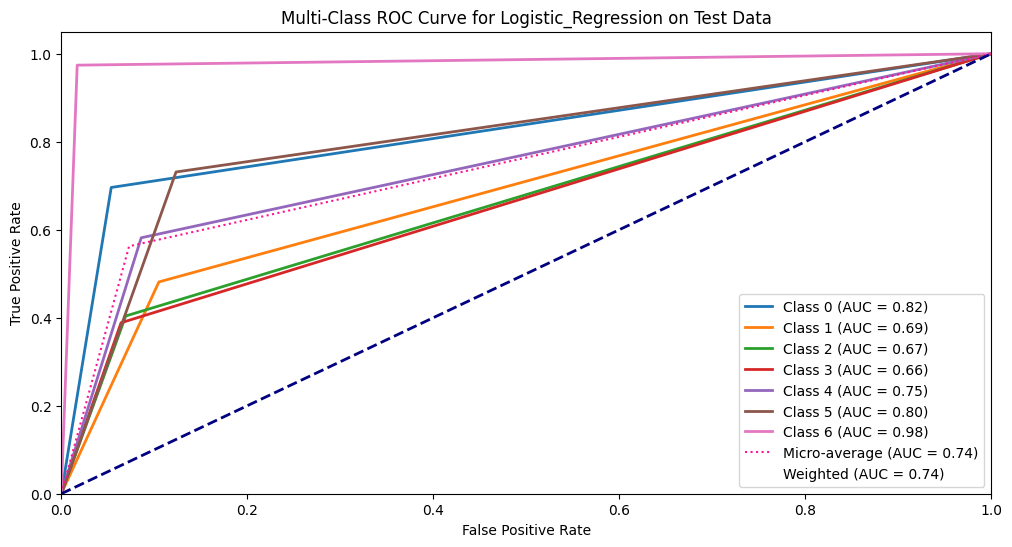

,Model,Fold,Train AUC ROC,Test AUC ROC
0,Logistic_Regression,0,0.868985,0.872843


In [24]:
train_vals = [y_train, y_train_pred]
test_vals = [y_test, y_test_pred]

performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Train AUC ROC', 'Test AUC ROC'])
generate_performance_values_plots(train_vals, test_vals, label_mapping, performance_metric_values, 'Logistic_Regression', 0)